### This is a notebook for comparing predicted segmentation with ground truth segmentations (validation dataset)

In [1]:
from cellpose import utils, dynamics, metrics, plot, io
from numba import jit
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import convolve, mean
import numpy as np
import matplotlib.pyplot as plt

### Loading of *_seg.npy files which contains 

In [14]:
!pwd

/dtu/blackhole/1d/203261/DL_project/Cell_Segmentation_DL_project/ona/validation


In [13]:
import os, io
current_dir = os.getcwd()

# putting .npy files into a list and sorting the list
ground_truth = [file for file in os.listdir("ground_truth") if file.endswith(".npy")]    
cyto3_pred = [file for file in os.listdir("cyto3_predictions") if file.endswith(".npy")]
retrained_pred = [file for file in os.listdir("retrained_predictions") if file.endswith(".npy")] 
fined_tuned_pred = [file for file in os.listdir("fined_tuned_predictions") if file.endswith(".npy")]

ground_truth_npy = sorted(ground_truth)
retrained_pred = sorted(retrained_pred)
fine_tuned_pred = sorted(fined_tuned_pred)
cyto3_pred_npy = sorted(cyto3_pred)

print(ground_truth_npy)
print(retrained_pred)
print(fine_tuned_pred)
print(cyto3_pred_npy)

# loading each .npy file into a list and extract only the 'masks' field
groundtruth_masks = [np.load(os.path.join("ground_truth", file), allow_pickle=True).item()['masks'] for file in ground_truth]
cyto3_pred_masks = [np.load(os.path.join("cyto3_predictions", file), allow_pickle=True).item()['masks'] for file in cyto3_pred]
retrained_pred_masks = [np.load(os.path.join("retrained_predictions", file), allow_pickle=True).item()['masks'] for file in retrained_pred]
fined_tuned_pred_masks = [np.load(os.path.join("fined_tuned_predictions", file), allow_pickle=True).item()['masks'] for file in fined_tuned_pred]

#print("Number of .npy files loaded:", len(fined_tuned_pred_masks))

['tile_0003_0023_seg.npy', 'tile_0003_0024_seg.npy', 'tile_0003_0025_seg.npy', 'tile_0003_0027_seg.npy', 'tile_0009_0011_seg.npy', 'tile_0009_0012_seg.npy', 'tile_0027_0010_seg.npy', 'tile_0027_0011_seg.npy', 'tile_0027_0012_seg.npy', 'tile_0027_0013_seg.npy', 'tile_0027_0014_seg.npy', 'tile_0029_0008_seg.npy', 'tile_0029_0009_seg.npy', 'tile_0029_0010_seg.npy', 'tile_0029_0011_seg.npy', 'tile_0029_0012_seg.npy', 'tile_0029_0013_seg.npy', 'tile_0029_0014_seg.npy', 'tile_0029_0015_seg.npy', 'tile_0029_0016_seg.npy']
['tile_0003_0023_seg.npy', 'tile_0003_0024_seg.npy', 'tile_0003_0025_seg.npy', 'tile_0003_0027_seg.npy', 'tile_0009_0011_seg.npy', 'tile_0009_0012_seg.npy', 'tile_0027_0010_seg.npy', 'tile_0027_0011_seg.npy', 'tile_0027_0012_seg.npy', 'tile_0027_0013_seg.npy', 'tile_0027_0014_seg.npy', 'tile_0029_0008_seg.npy', 'tile_0029_0009_seg.npy', 'tile_0029_0010_seg.npy', 'tile_0029_0011_seg.npy', 'tile_0029_0012_seg.npy', 'tile_0029_0013_seg.npy', 'tile_0029_0014_seg.npy', 'tile_0029

In [40]:
#!pip install scikit-image
from skimage import io

dat = np.load('ground_truth/tile_0003_0023_seg.npy', allow_pickle=True).item()
img = io.imread('ground_truth/tile_0003_0023.png')
dat.keys()

dict_keys(['outlines', 'colors', 'masks', 'chan_choose', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path', 'flow_threshold', 'cellprob_threshold', 'normalize_params', 'restore', 'ratio', 'diameter'])

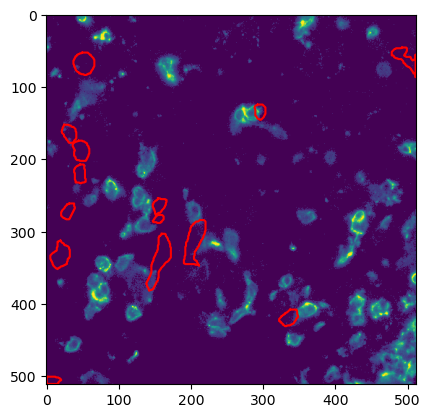

In [52]:
import numpy as np
from cellpose import plot, utils, io

dat1 = np.load('ground_truth/tile_0029_0015_seg.npy', allow_pickle=True).item()
dat2 = np.load('cyto3_predictions/tile_0029_0015_seg.npy', allow_pickle=True).item()

img = io.imread('ground_truth/tile_0029_0015.png')

# plot image with masks overlaid
mask_RGB = plot.mask_overlay(img, dat['masks'])

# plot image with outlines overlaid in red
outlines = utils.outlines_list(dat['masks'])
plt.imshow(img)
for o in outlines:
    plt.plot(o[:,0], o[:,1], color='r')

In [42]:
cyto3_data['masks']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

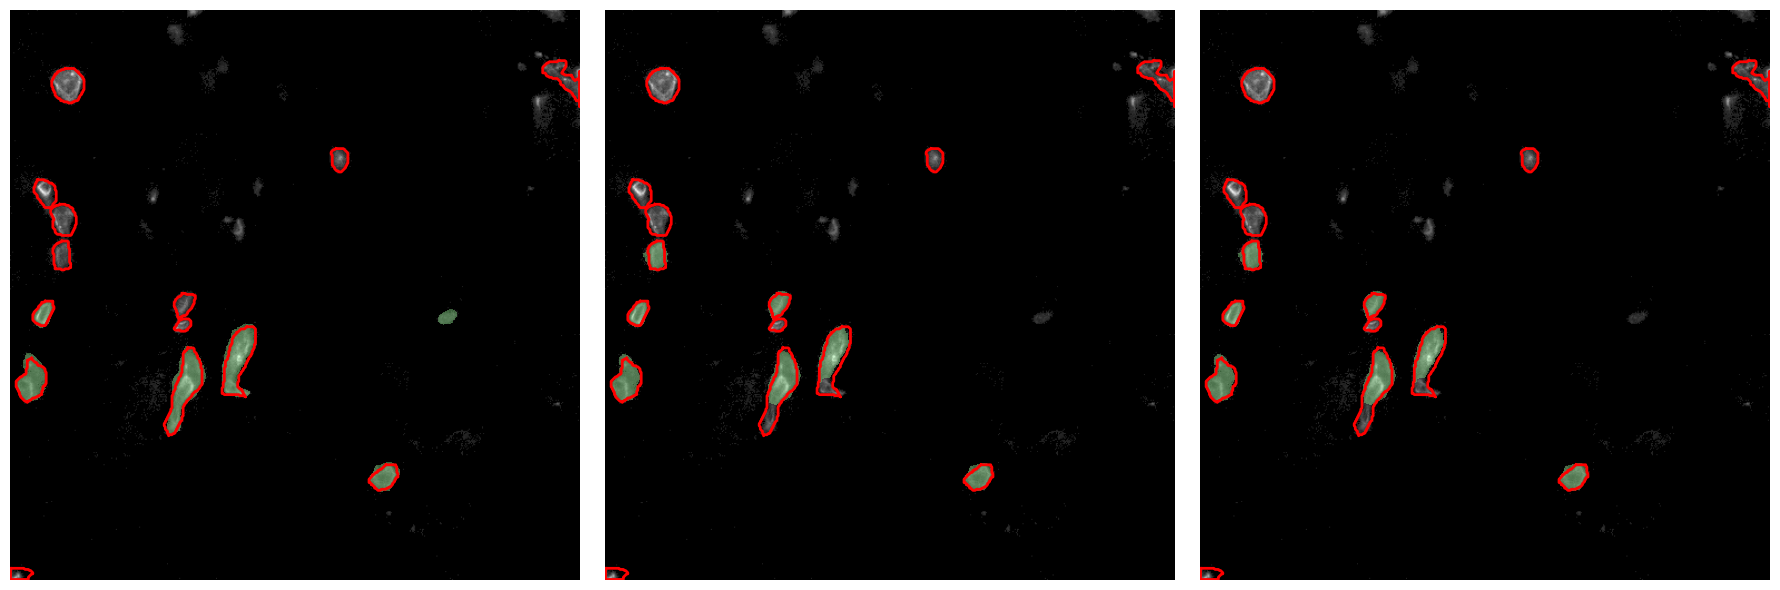

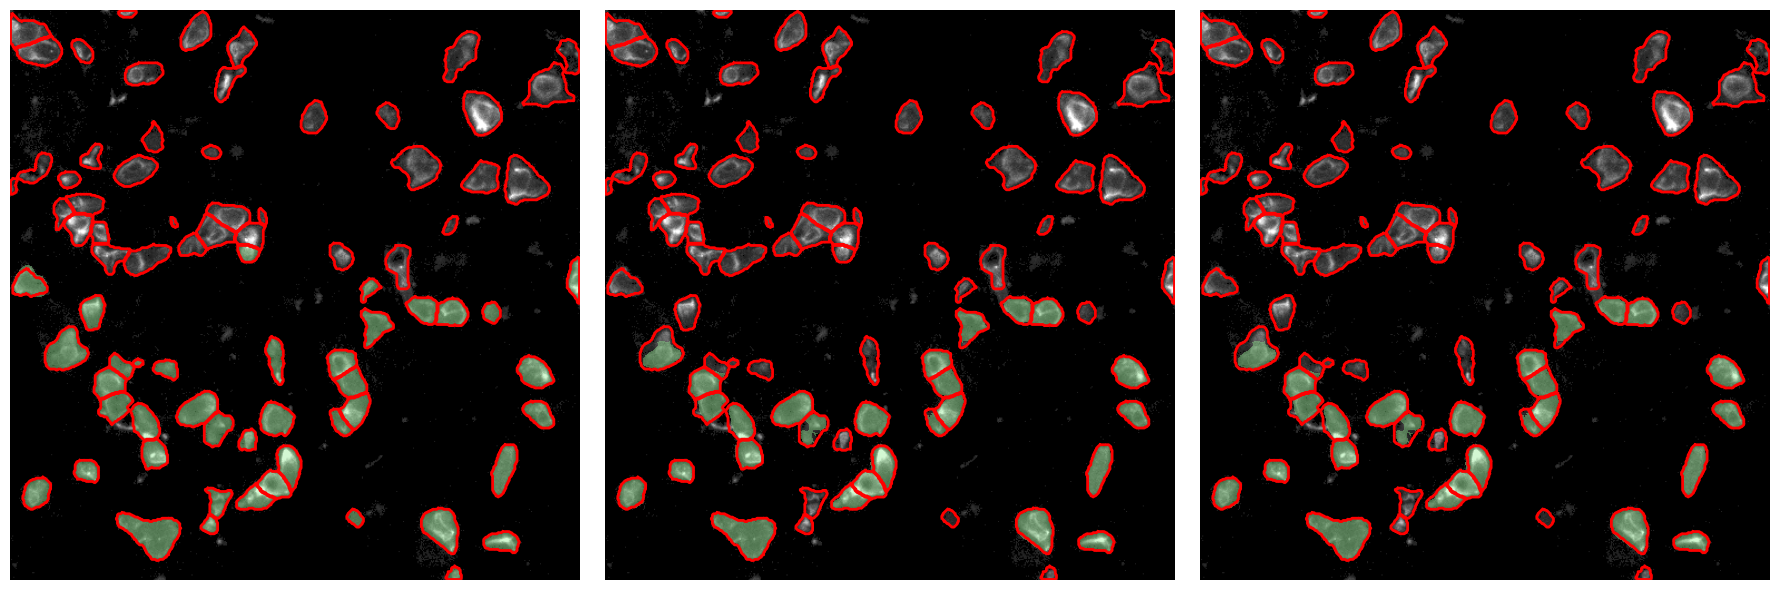

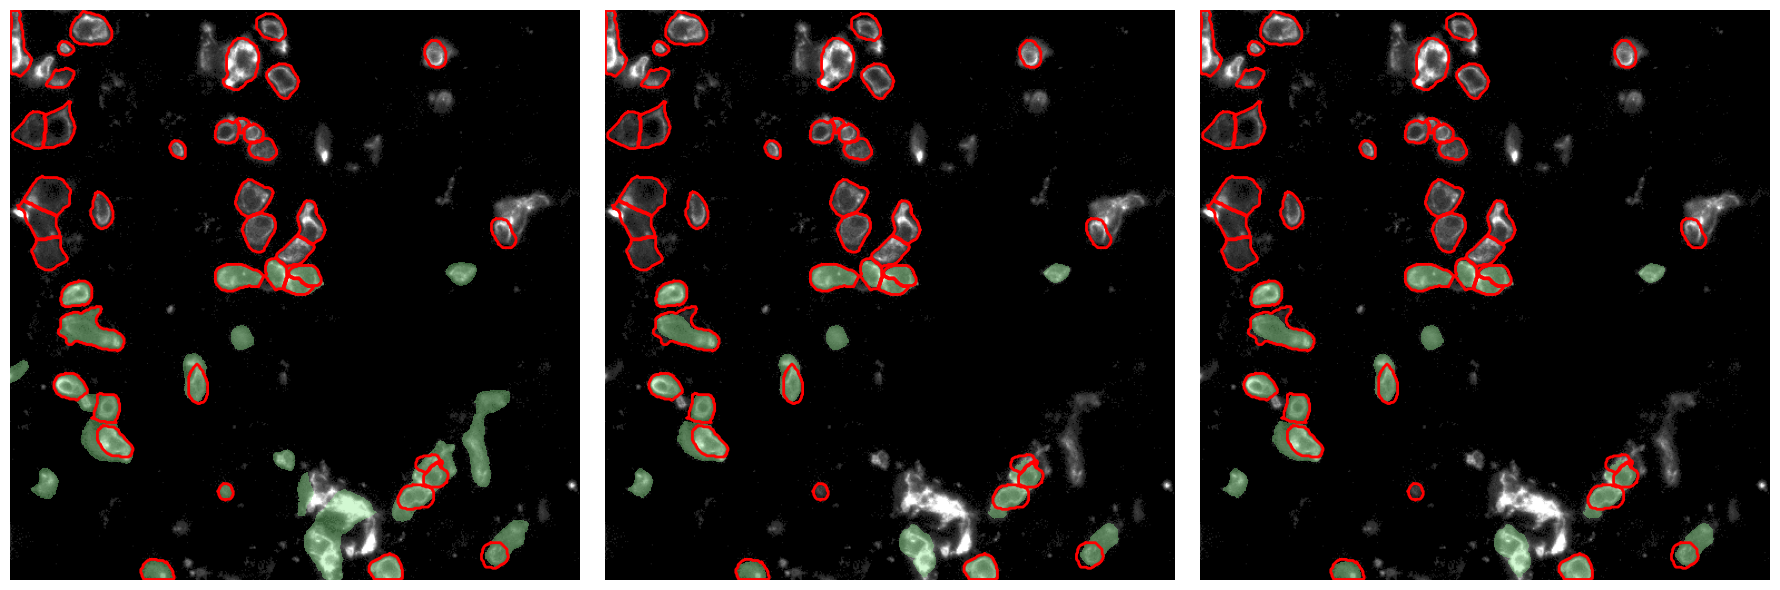

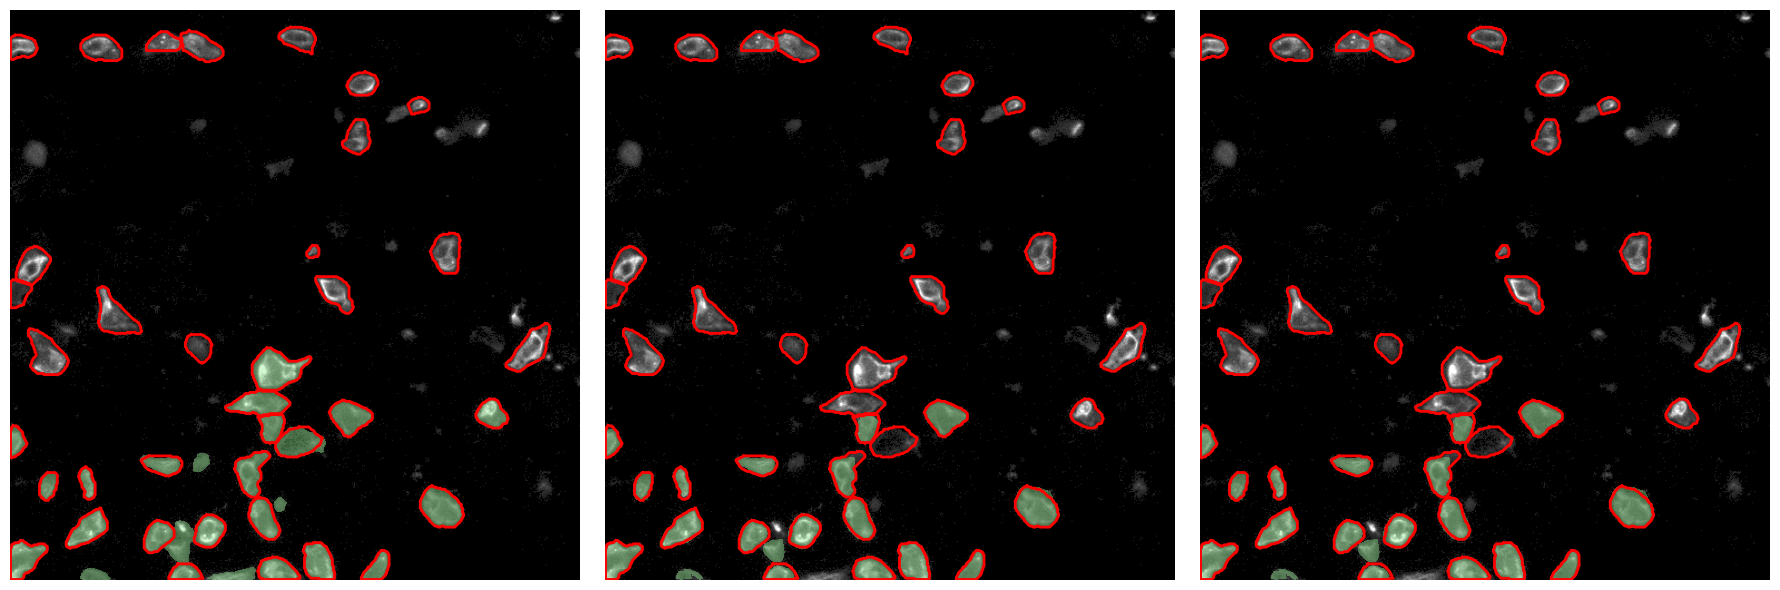

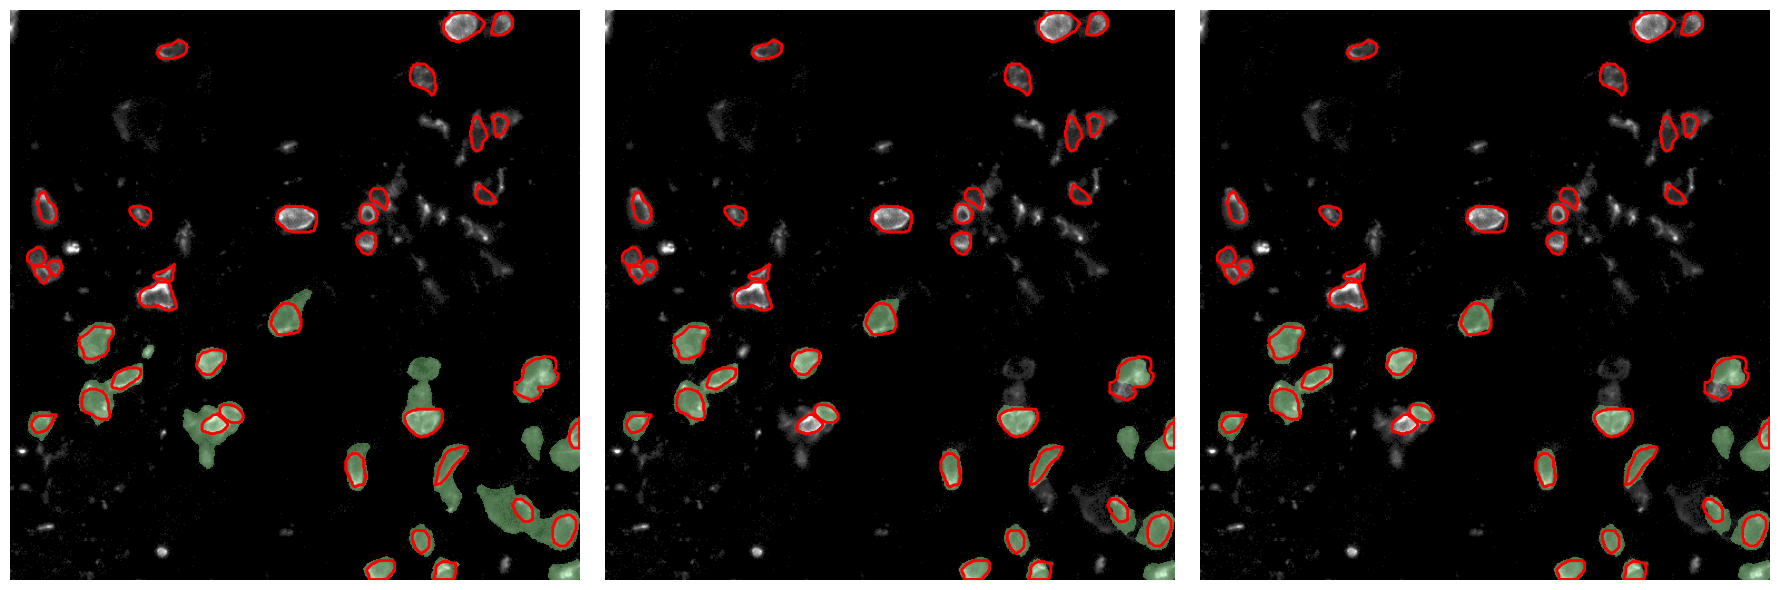

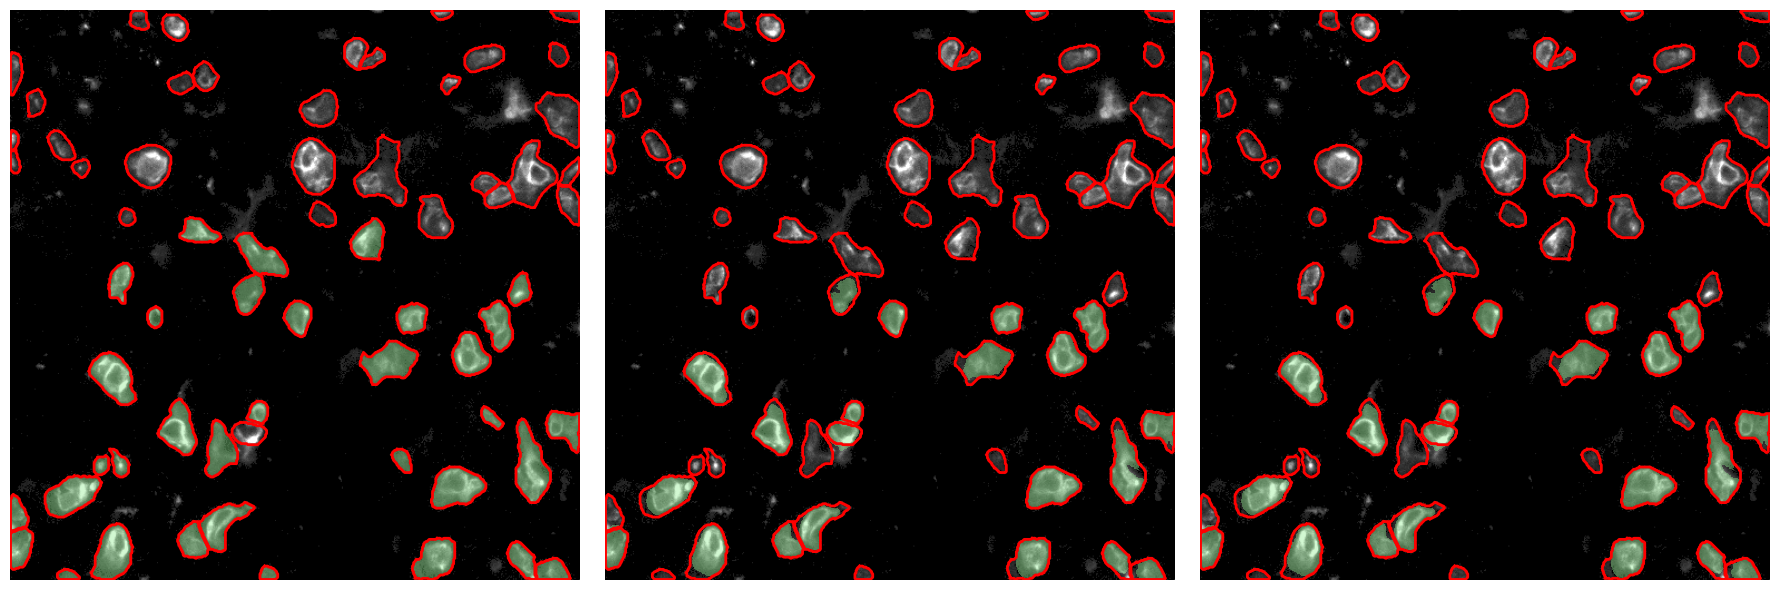

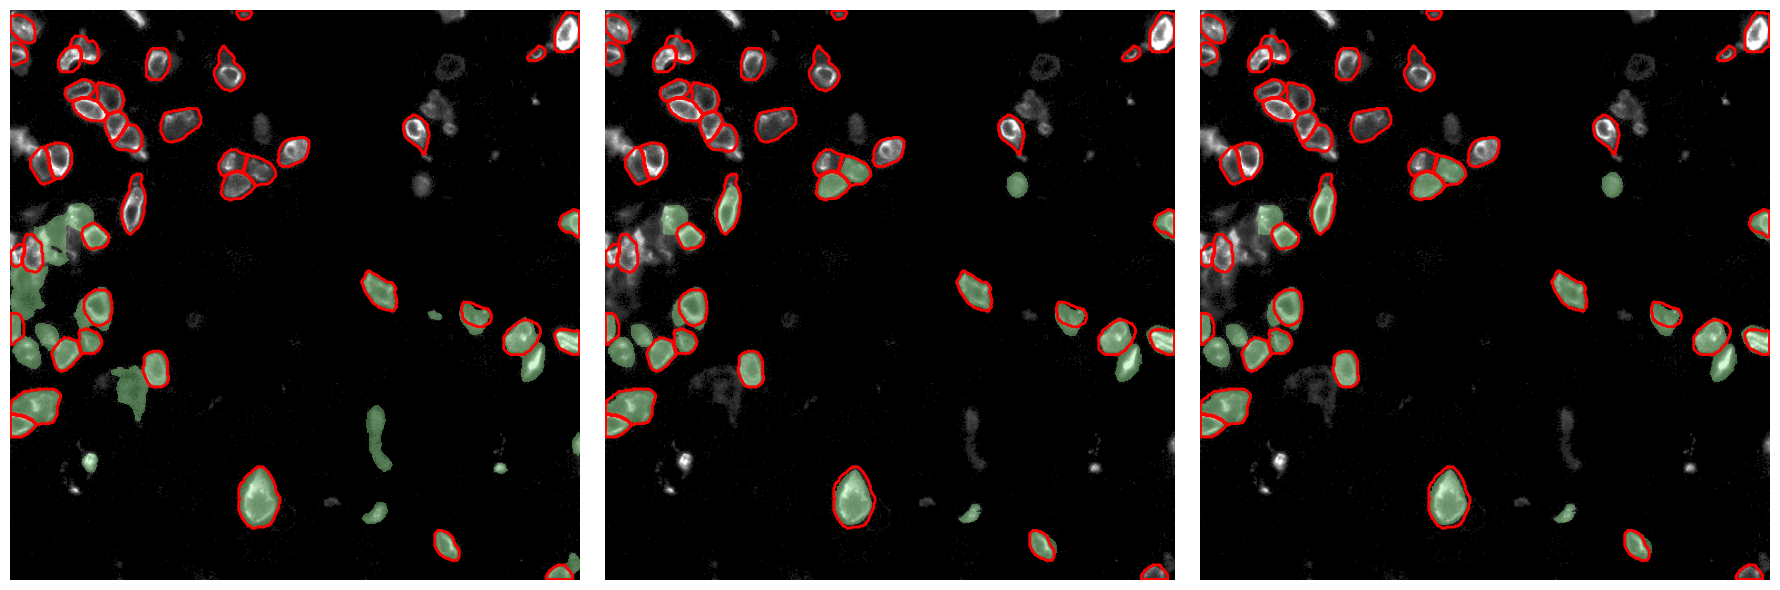

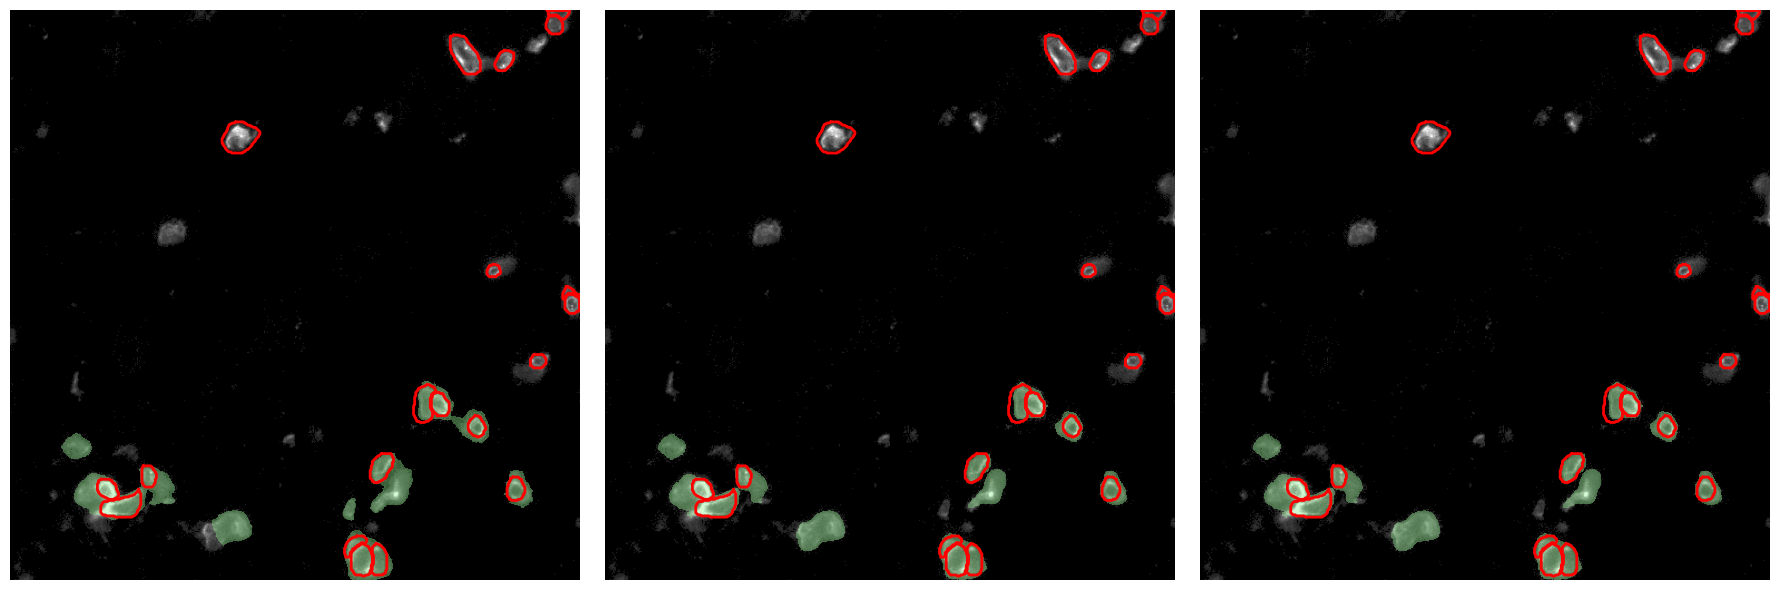

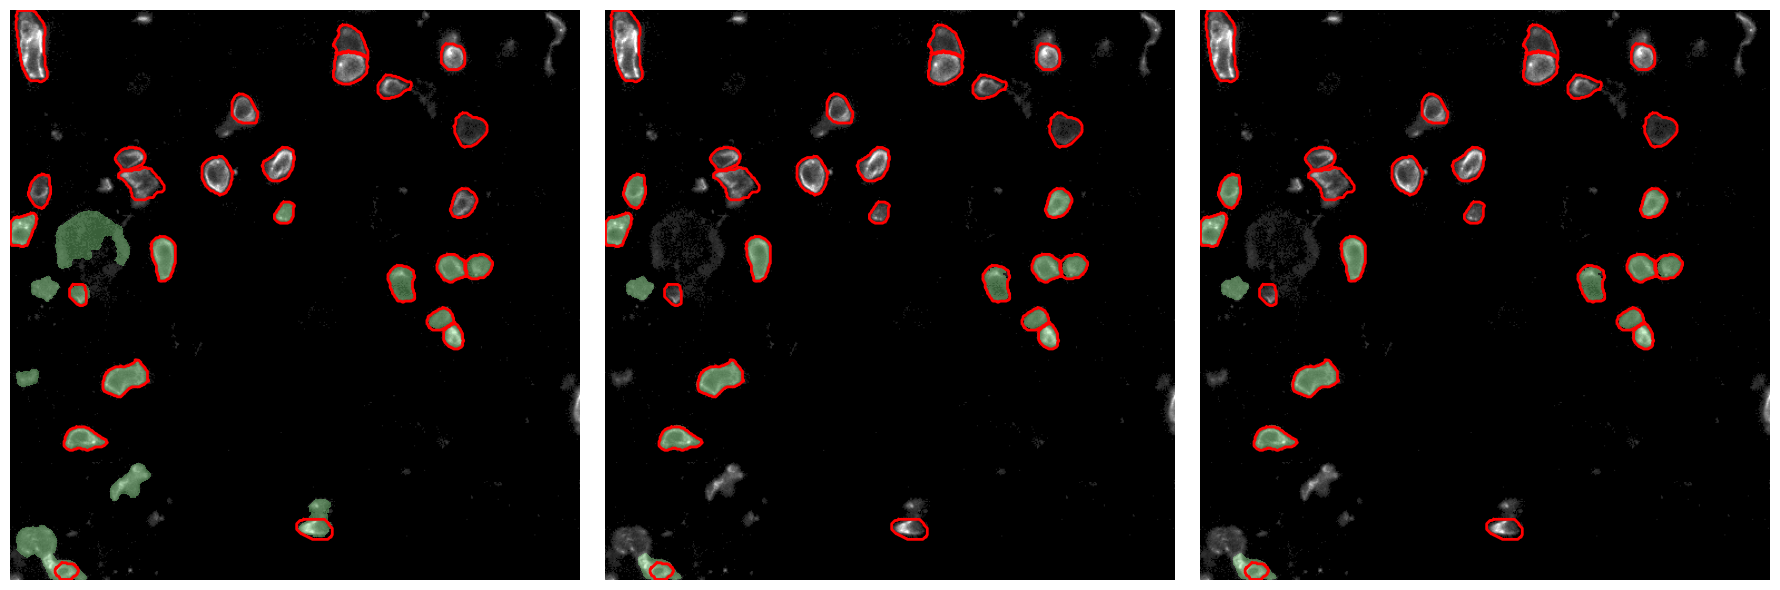

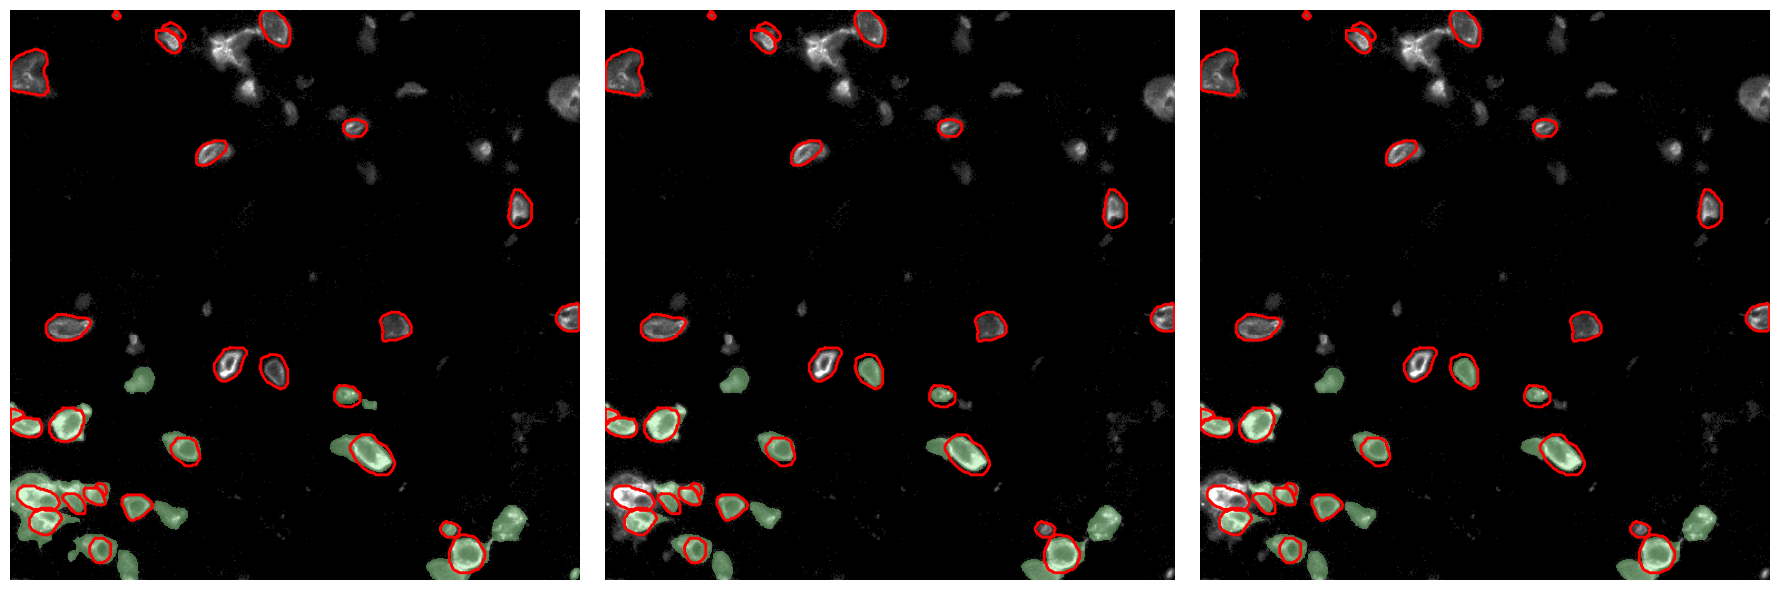

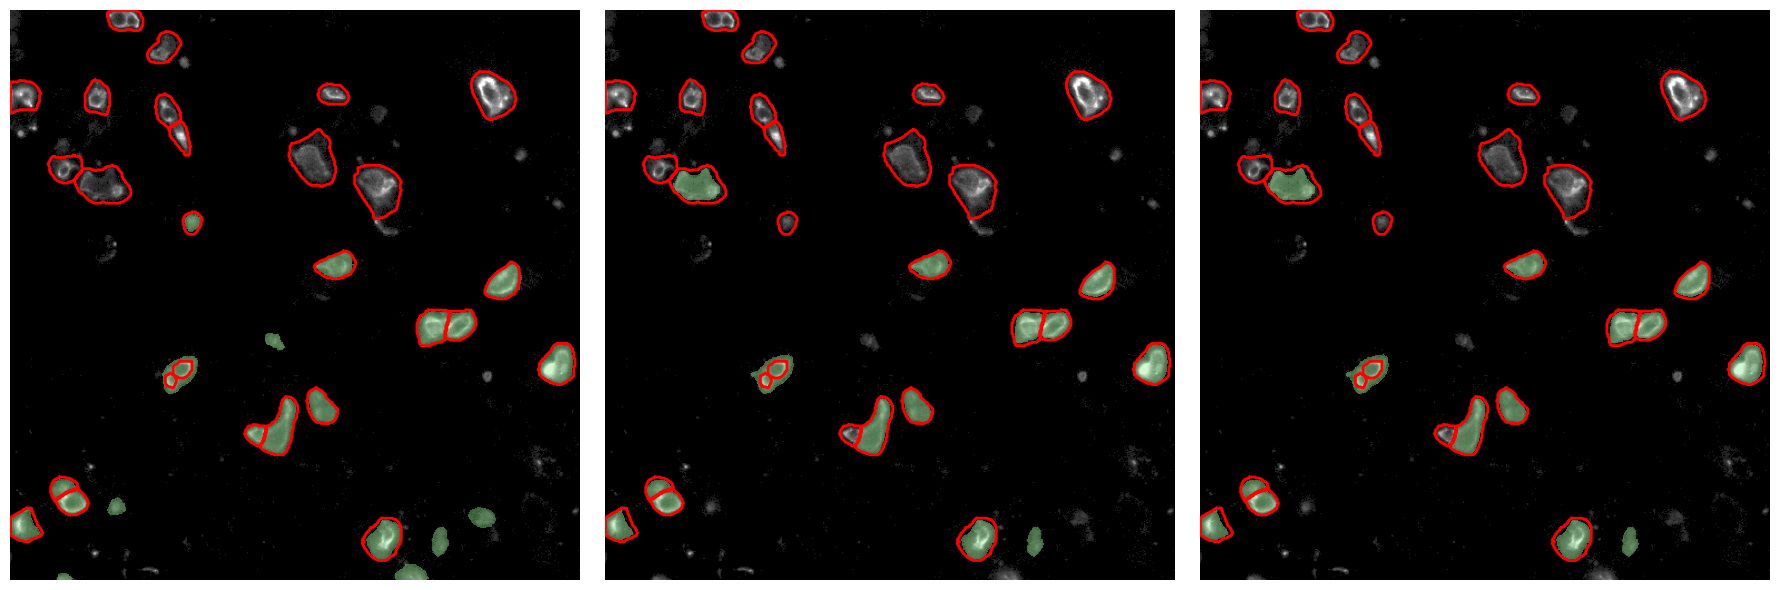

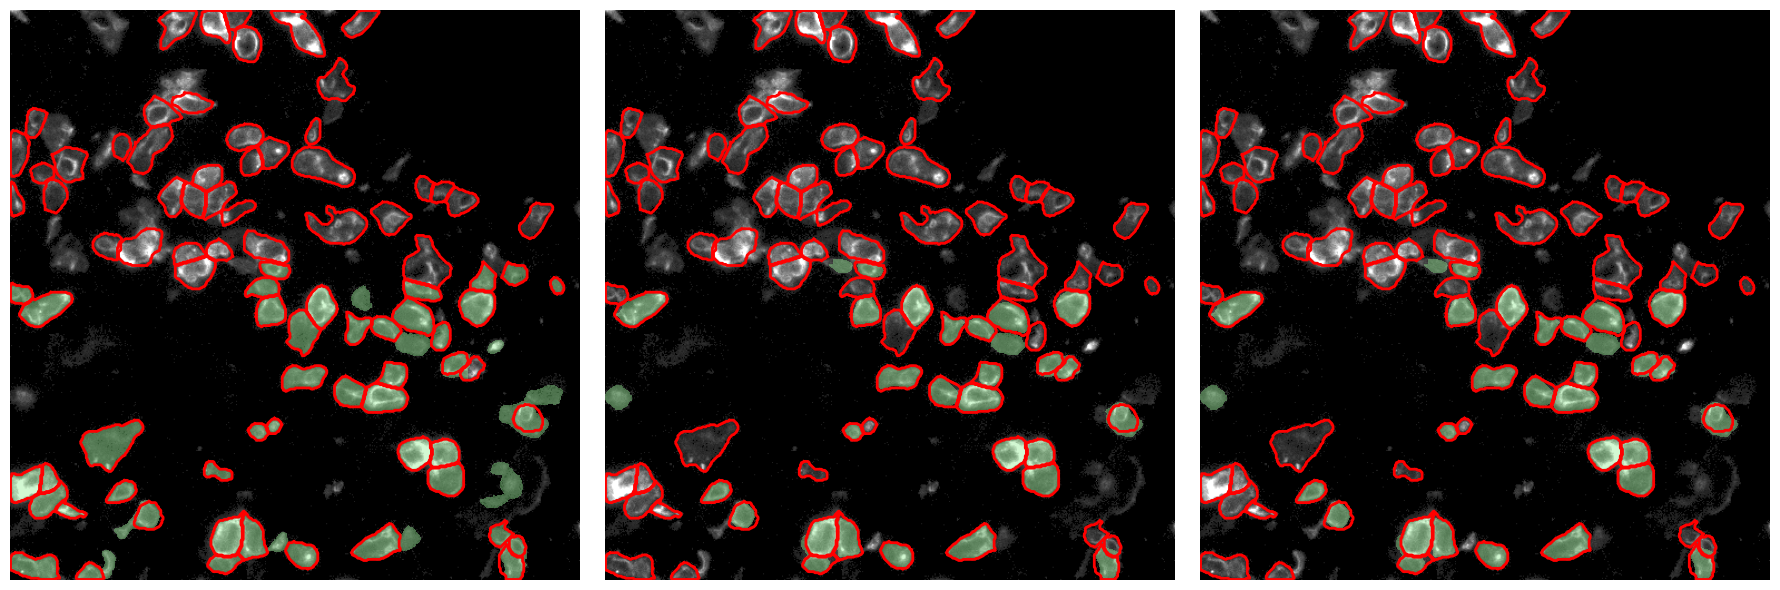

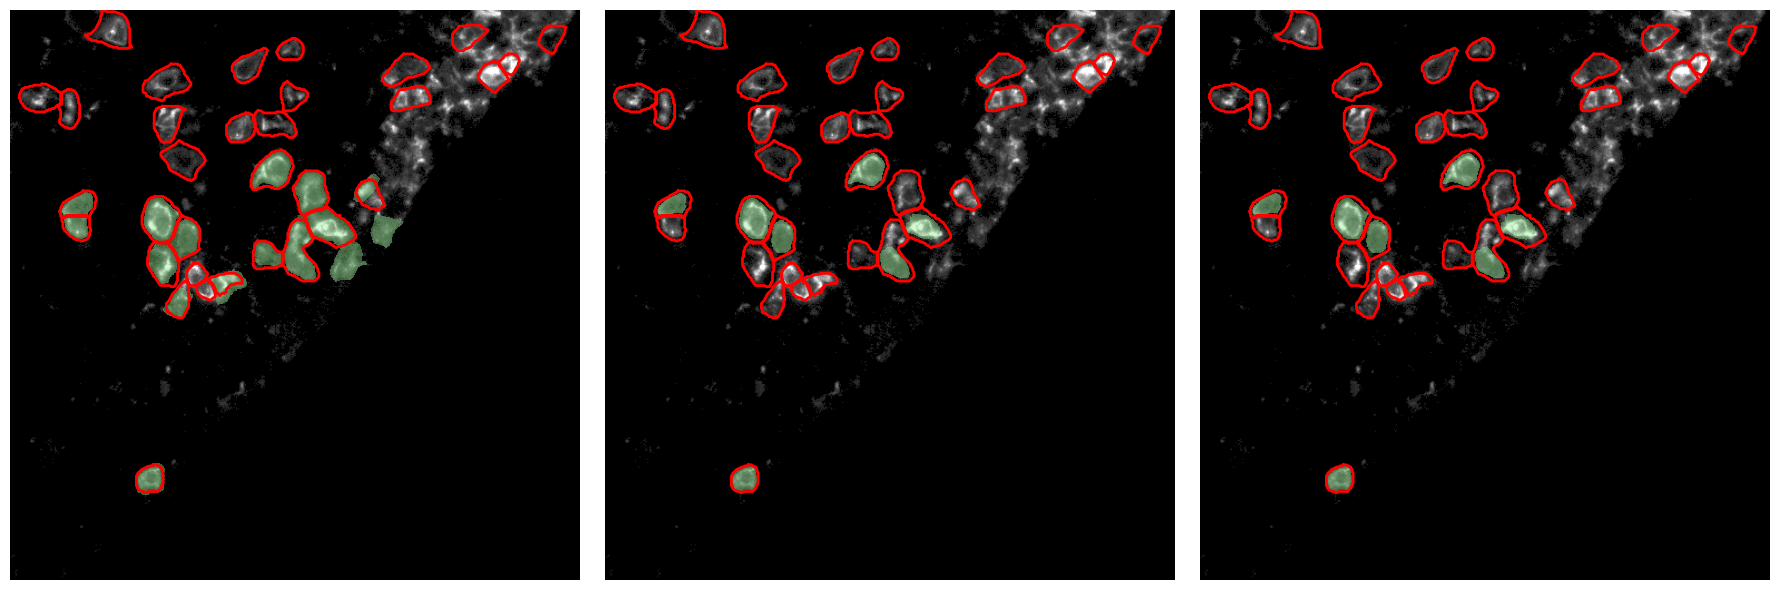

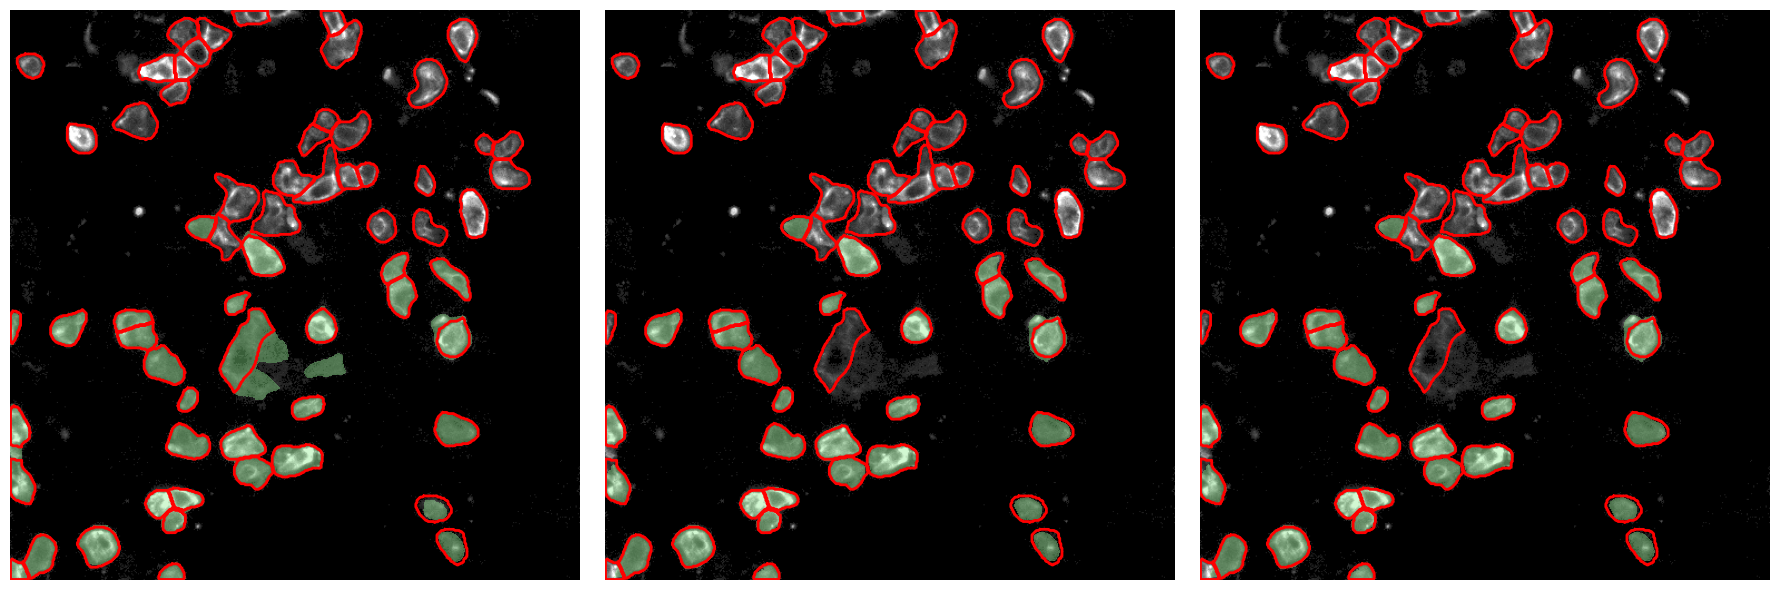

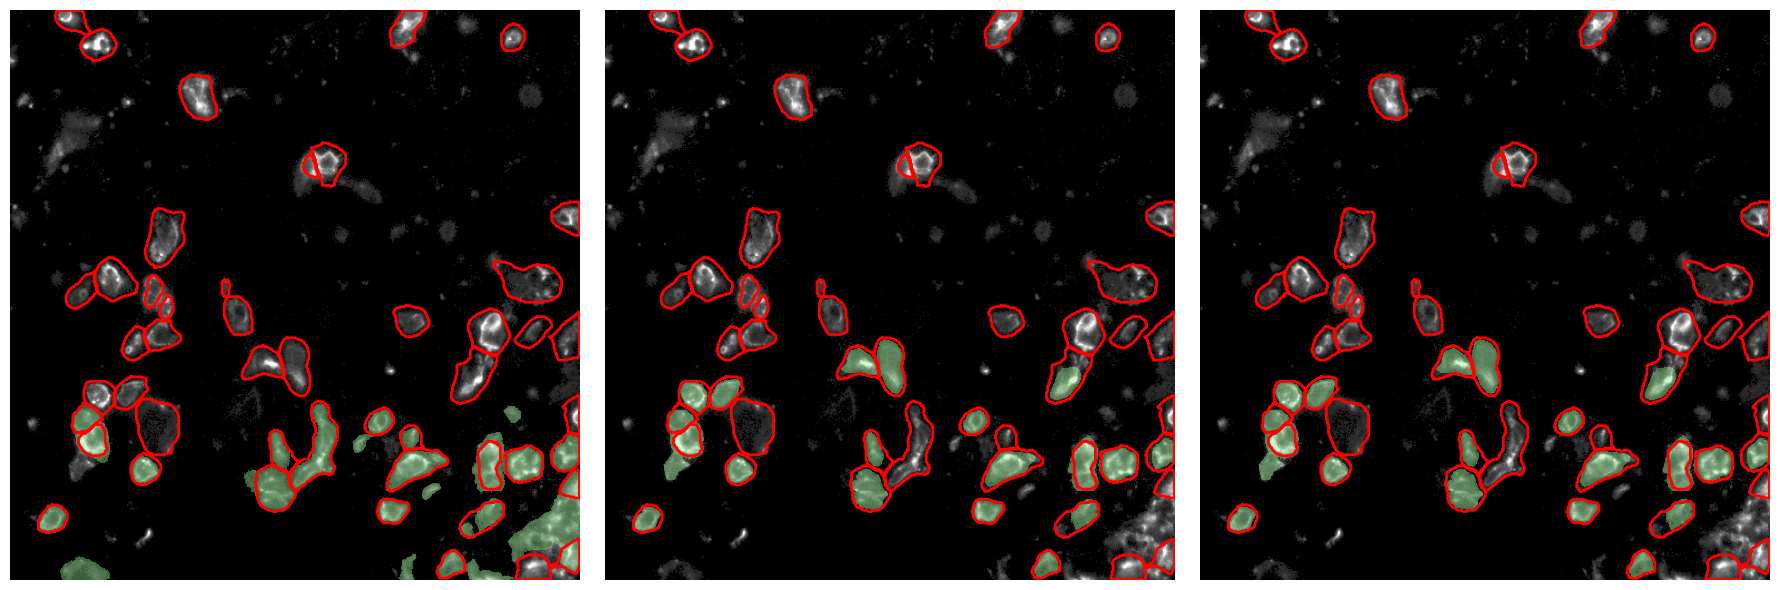

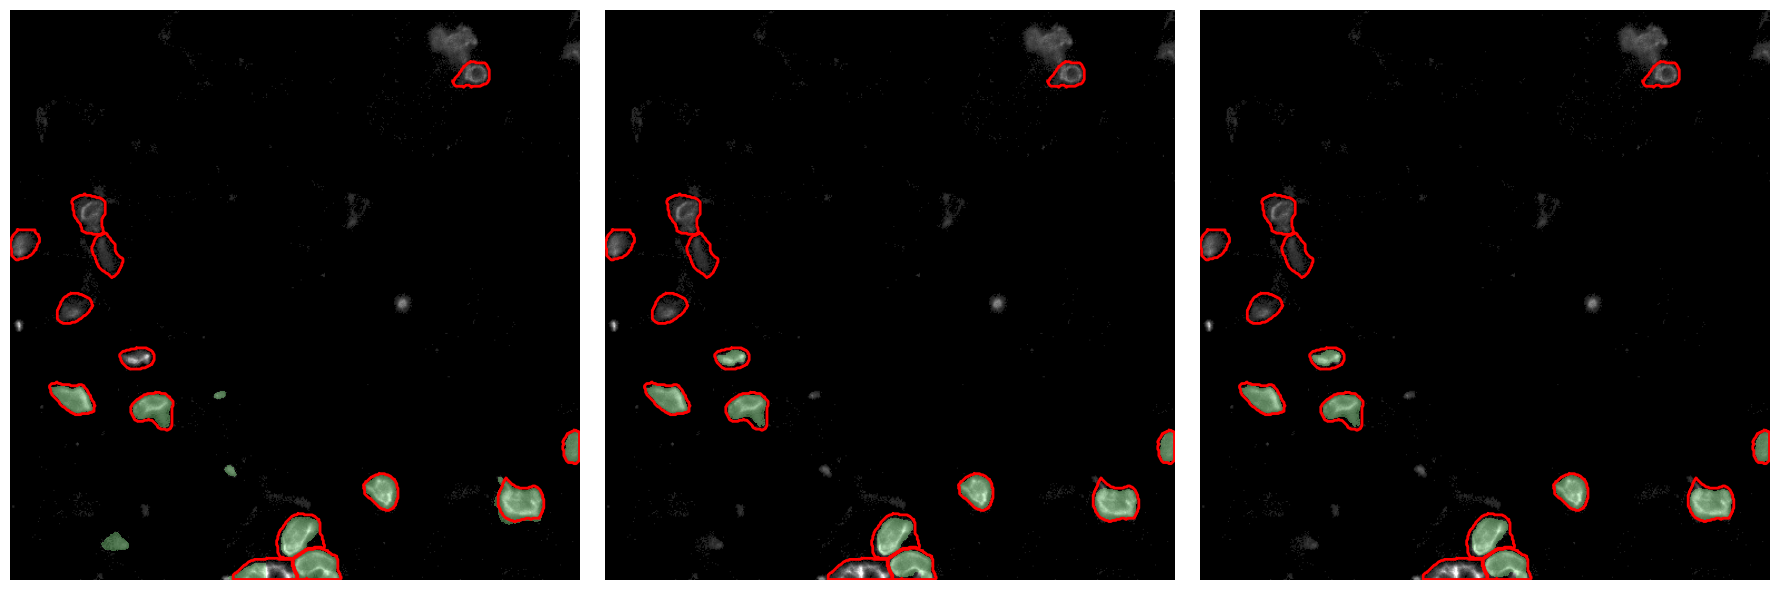

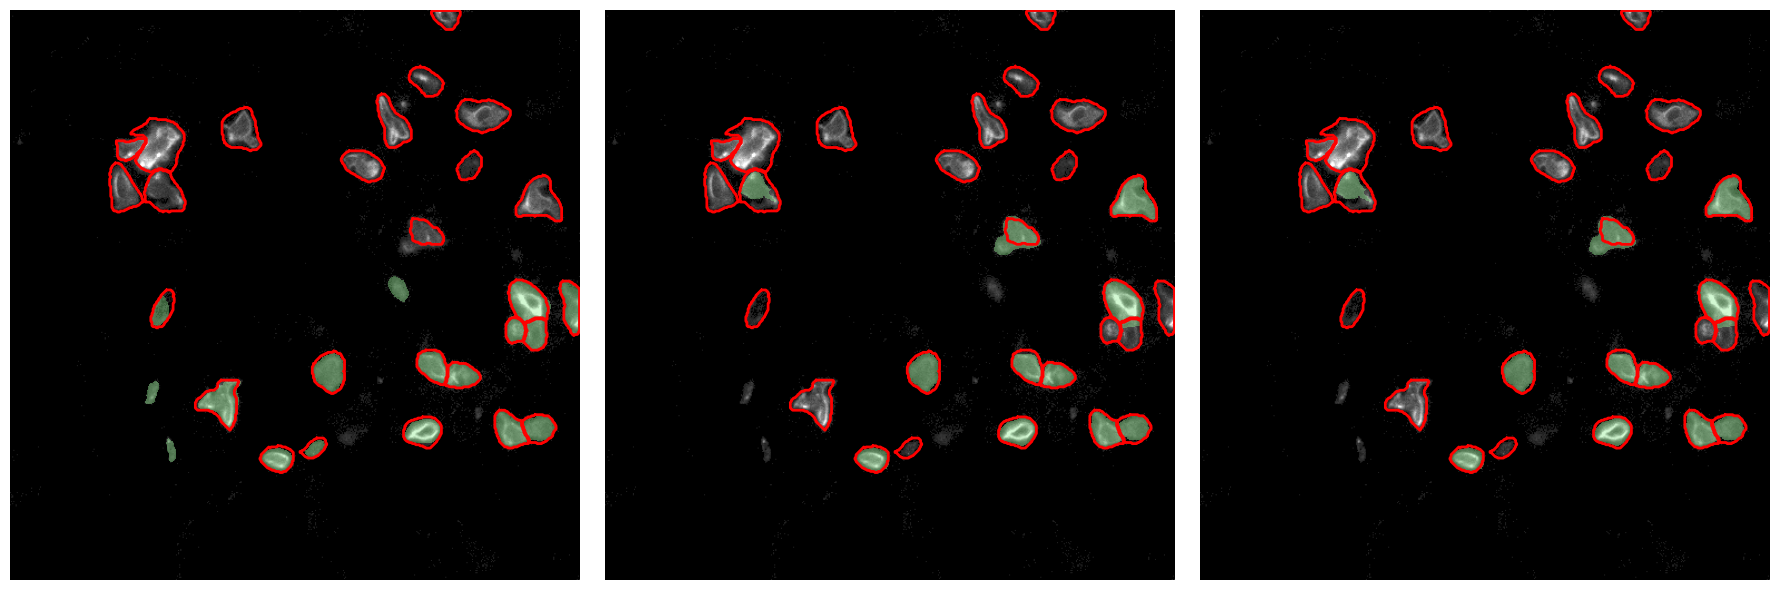

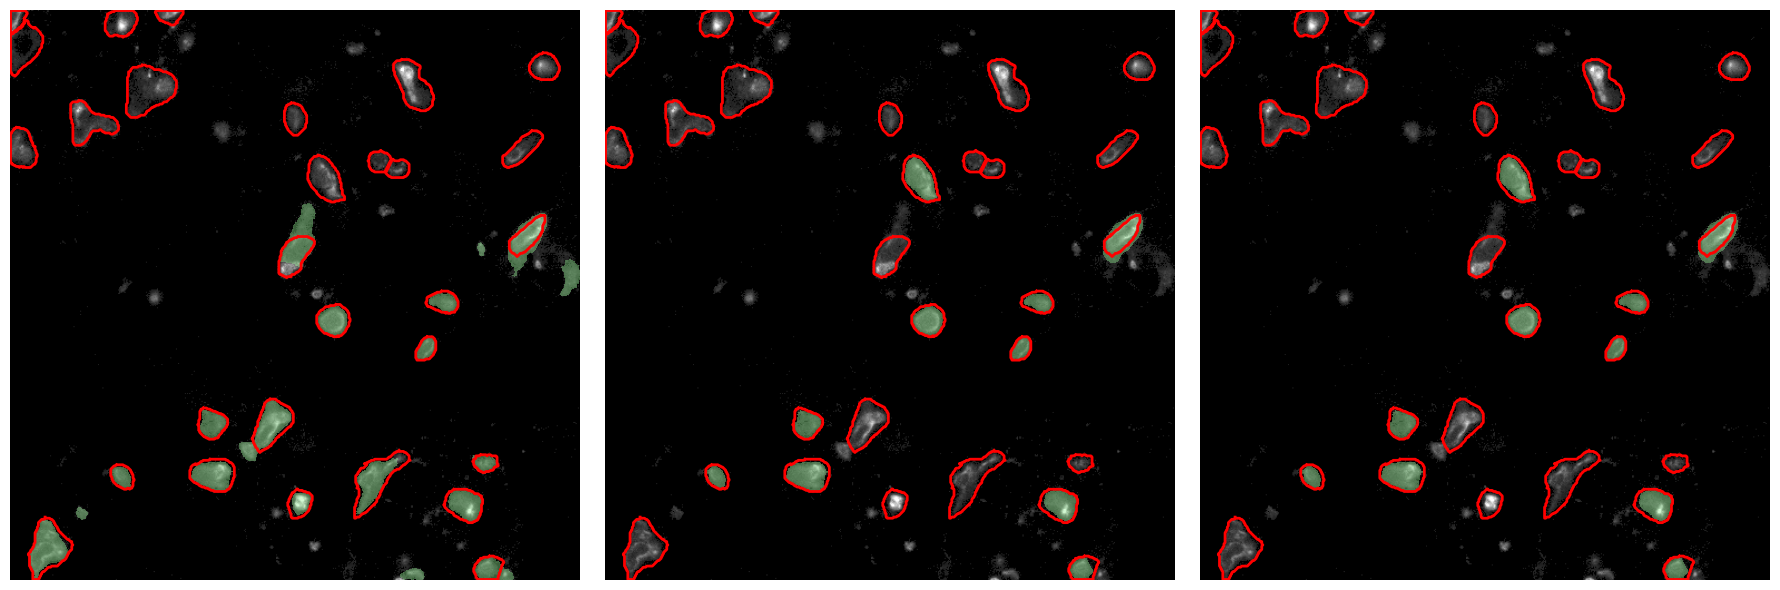

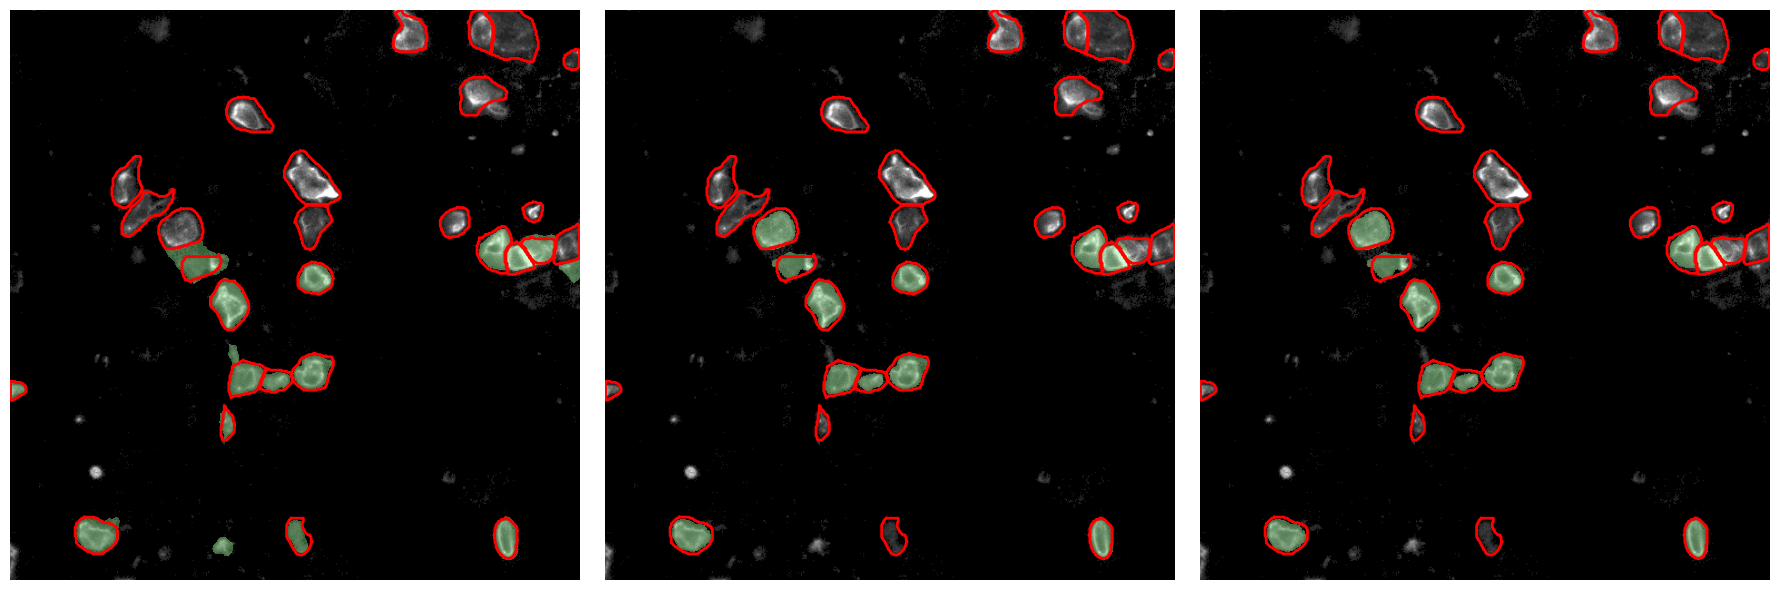

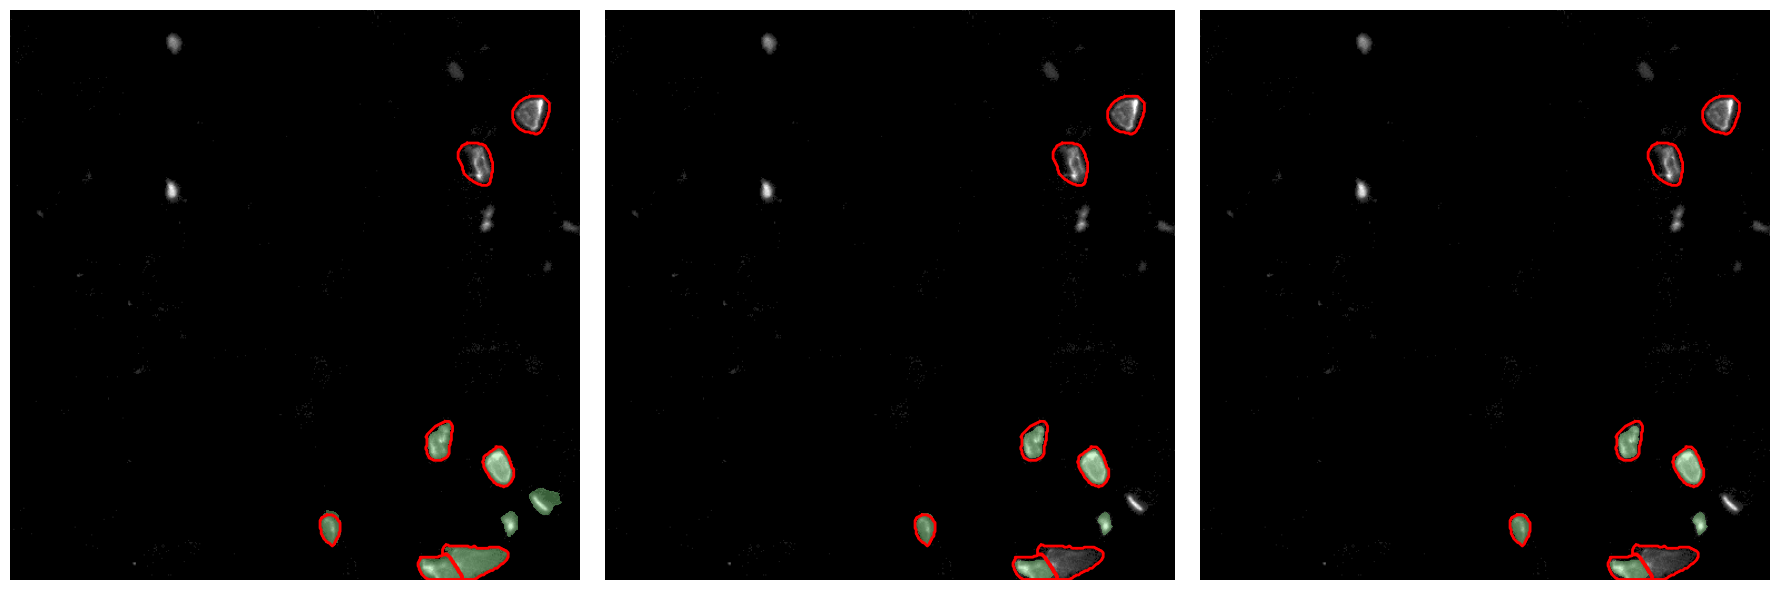

In [43]:
import numpy as np
from cellpose import utils, io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

# Define paths
ground_truth_dir = "ground_truth"
cyto3_predictions_dir = "cyto3_predictions"
fined_tuned_predictions_dir = "fined_tuned_predictions"
retrained_predictions_dir = "retrained_predictions"

# Get all files in directories
ground_truth_files = [f for f in os.listdir(ground_truth_dir) if f.endswith("_seg.npy")]

# Function to overlay masks with light green coloring
def overlay_masks(image, masks, ax, title, alpha=0.4):    
    # Create light green colormap
    ax.imshow(image, cmap='gray')
    light_green_cmap = ListedColormap(["blue", "lightgreen"])  # Transparent background and light green masks
    ax.imshow(masks, cmap=light_green_cmap, alpha=alpha)
    ax.set_title(title)
    ax.axis('off')

# Function to plot ground truth outlines in green
def plot_outlines(image, masks, ax, title, outline_color='green'):
    ax.set_title(title)
    ax.axis('off')
    outlines = utils.outlines_list(masks)
    for outline in outlines:
        ax.plot(outline[:, 0], outline[:, 1], color=outline_color, lw=2)

# Iterate over each file in the ground truth directory
for file in ground_truth_files:
    # Load data
    gt_data = np.load(os.path.join(ground_truth_dir, file), allow_pickle=True).item()
    img_file = file.replace("_seg.npy", ".png")
    img = io.imread(os.path.join(ground_truth_dir, img_file))
    
    # Load predictions
    cyto3_data = np.load(os.path.join(cyto3_predictions_dir, file), allow_pickle=True).item()
    fined_tuned_data = np.load(os.path.join(fined_tuned_predictions_dir, file), allow_pickle=True).item()
    retrained_data = np.load(os.path.join(retrained_predictions_dir, file), allow_pickle=True).item()
    
    # Create a 1x3 plot for the comparisons
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Ground truth outlines + cyto3 predictions
    overlay_masks(img, cyto3_data['masks'], axes[0], f"Ground Truth + Cyto3: {file}")
    plot_outlines(img, gt_data['masks'], axes[0], "", outline_color='red')
    
    # Ground truth outlines + fine-tuned predictions
    overlay_masks(img, fined_tuned_data['masks'], axes[1], f"Ground Truth + Fine-tuned: {file}")
    plot_outlines(img, gt_data['masks'], axes[1], "", outline_color='red')
    
    # Ground truth outlines + retrained predictions
    overlay_masks(img, retrained_data['masks'], axes[2], f"Ground Truth + Retrained: {file}")
    plot_outlines(img, gt_data['masks'], axes[2], "", outline_color='red')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()